# Create Map for the City of New Orleans

New Orleans maps are created by this notebook

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy
from datetime import datetime
import os
import pyproj

In [2]:
outPath = f"output{os.sep}"
dataPath = f"datasets{os.sep}"
wgs84 = pyproj.CRS.from_string('WGS84')

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-04-07 09:52:48.626913] Starting...


In [4]:
lp(f"outPath:  {outPath}")
lp(f"dataPath:  {dataPath}")

[2025-04-07 09:52:48.630558] outPath:  output/
[2025-04-07 09:52:48.630729] dataPath:  datasets/


In [5]:
lp("Loading 100m lidar data")
data100m = gpd.read_parquet(f"{outPath}PostProcessedLidat_100m.parquet")
bounds100m = data100m.total_bounds

[2025-04-07 09:52:48.634326] Loading 100m lidar data


In [6]:
lp("Loading 10m lidar data")
data10m = gpd.read_parquet(f"{outPath}PostProcessedLidat_10m.parquet")
bounds10m = data100m.total_bounds

[2025-04-07 09:52:48.721179] Loading 10m lidar data


In [7]:
crs = data100m.crs
lp(f"CRS:  {crs.name}")

[2025-04-07 09:52:54.107149] CRS:  NAD83(2011) / UTM zone 15N + NAVD88 height - Geoid18 (metres)


In [8]:
lp("Creating CRS transformers")
crsToWgs84 = pyproj.Transformer.from_crs(crs_from=crs, crs_to=wgs84)
lp(crsToWgs84)

[2025-04-07 09:52:54.111473] Creating CRS transformers
[2025-04-07 09:52:54.126421] proj=pipeline step inv proj=utm zone=15 ellps=GRS80 step proj=unitconvert xy_in=rad xy_out=deg step proj=axisswap order=2,1


In [9]:
lp("Loading neighborhoos data")
neighborhoodsDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").set_index('gnocdc_lab').to_crs(crs)
neighborhoodsDf.head(2)

[2025-04-07 09:52:54.130142] Loading neighborhoos data


,neigh_id,objectid,lup_lab,shape_stlength,shape_starea,geometry
gnocdc_lab,,,,,,
B. W. COOPER,12D,6,B. W. COOPER HOUSING DEV,12118.012710324232,8808477.0902902912,"MULTIPOLYGON (((781325.808 3316870.195, 781298..."
HOLY CROSS,15C,32,HOLY CROSS,21187.180302661334,26999609.302162763,"MULTIPOLYGON (((788931.478 3317916.911, 788404..."


In [10]:
lp("Loading water")
waterDf = gpd.read_file(f"{dataPath}WATER2.SHP").set_crs(wgs84).to_crs(crs)

[2025-04-07 09:52:54.193326] Loading water


/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 3 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geom

In [11]:
data100m.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'Int', 'Total', 'RunTime',
       'MeanAltitude', 'MeanIntensity', 'PercentWater', 'IsInterpolated'],
      dtype='object')

In [12]:
np.count_nonzero(data10m['Total'] > 0)

4034499

In [13]:
def tickPtFormater(pt):

    deg = int(pt)
    mins = round((pt - deg) * 60)
    
    return f"{deg}\u00B0 {mins}'"

def tickFormater(x,y):
    wgsPTS = crsToWgs84.transform(x,y)

    formated = tuple(map(tickPtFormater, wgsPTS))

    return formated

In [14]:
data100m.head(1)

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater,IsInterpolated
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0,0,0,0,0 days 00:00:00.228102,9.701096,626,0.137147,True


In [15]:
cartopyCRS = cartopy.crs.UTM(15)
def createMap(ax, df,column,bounds,vmin,vmax,cmap='seismic_r', alpha=0.5, tickSpacing=10000, zorderPlus = 0,\
              showColorBar=True):

    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmapTrans = matplotlib.colormaps.get_cmap(cmap)
    xMidpoint = bounds[2] - bounds[0]
    yMidpoint = bounds[3] - bounds[1]
    
    #data100m.plot(ax=ax,column='Altitude', legend=True)
    colors = cmapTrans( normalizer( df[column] ) )
    colors[:,3] = alpha
    
    ax.add_geometries(df['geometry'], crs=cartopyCRS, color=colors, edgecolor=None, zorder=5+zorderPlus)
    
    ax.add_geometries(df[df['PercentWater']>=50]['geometry'], crs=cartopyCRS, color='lightblue', edgecolor=None, zorder=6+zorderPlus)
    waterDf.plot(ax=ax, color='lightblue', edgecolor='lightblue', label='water',zorder=10+zorderPlus)
    
    ax.set_xlim((bounds[0], bounds[2]))
    ax.set_ylim((bounds[1], bounds[3]))

    

    ax.xaxis.set_major_formatter(lambda x, pos: tickFormater(x,yMidpoint)[1])
    ax.yaxis.set_major_formatter(lambda y, pos: tickFormater(xMidpoint,y)[0])
    ax.tick_params(which='both')
    
    ax.set_xticks(np.arange(bounds[0]+tickSpacing, bounds[2], tickSpacing))
    ax.set_yticks(np.arange(bounds[1]+tickSpacing, bounds[3], tickSpacing))

    if showColorBar:
        matplotlib.pyplot.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=cmapTrans, norm=normalizer) , ax=ax)

    ax.patch.set_facecolor((1, 0.996, 0.859,1.0))

    ax.set_aspect('equal')

    return ax




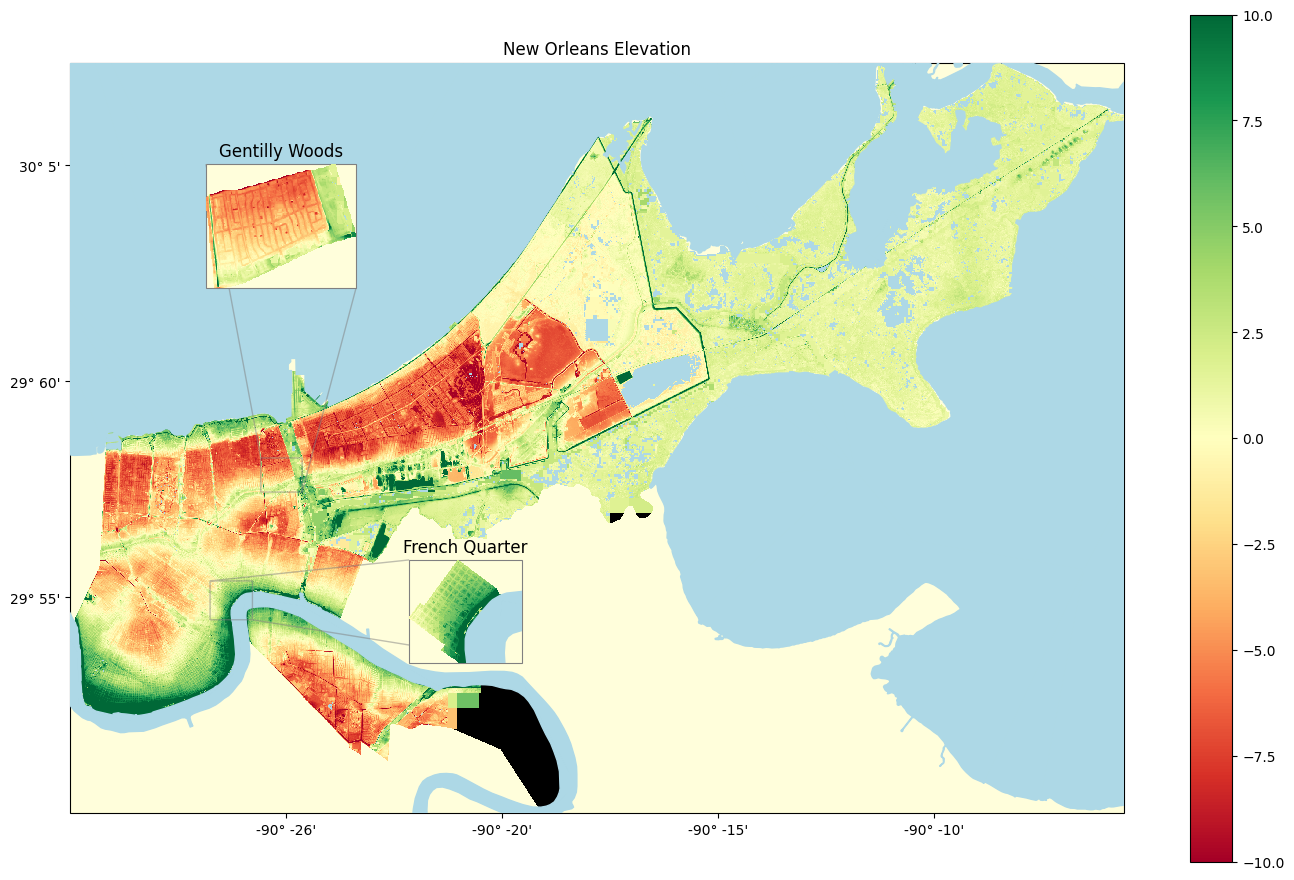

In [16]:
clipping = 10

fig, ax = plt.subplots(figsize=(17,11), subplot_kw={ 'projection':cartopyCRS})
createMap(ax, data10m, 'MeanAltitude', data10m.total_bounds , vmin=clipping*-1, vmax=clipping, alpha=1, cmap='RdYlGn')
ax.set_title("New Orleans Elevation")


subPlotHoods = [
    [[0.1,0.7,0.2], 'GENTILLY WOODS'],
    [[0.3,0.2,0.15], 'FRENCH QUARTER'],

]
for loc, hood in subPlotHoods:
    
    geomHood = neighborhoodsDf.loc[hood,'geometry']
    geomBounds = geomHood.bounds
    hoodMask = data10m.intersects(geomHood)

    geomHeightRatio = ((geomBounds[3] - geomBounds[1]) / (geomBounds[2] - geomBounds[0]))
    
    loc.append( geomHeightRatio * loc[2] )
    
    axHood = ax.inset_axes(loc, projection=cartopyCRS, zorder=51)
    for spine in axHood.spines.values():
        spine.set_edgecolor('grey')
    
    createMap(axHood, data10m[hoodMask], 'MeanAltitude', geomBounds ,\
              vmin=clipping*-1, vmax=clipping, alpha=1, cmap='RdYlGn',
              showColorBar=False)

    axHood.set_title(hood.title())
    ax.indicate_inset_zoom(axHood, zorder=50, edgecolor='grey')

fig.savefig('output/NewOrleans10m.jpg')

In [17]:
lp("done")

[2025-04-07 10:04:28.485188] done
